In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.base import TransformerMixin, BaseEstimator
from collections import OrderedDict

import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 16})
sns.set_style('whitegrid')
from tqdm.notebook import tqdm
from IPython.display import clear_output
from matplotlib import ticker
# unused but required import for doing 3d projections with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401
from sklearn import manifold

from category_encoders.target_encoder import TargetEncoder
from imblearn.under_sampling import NearMiss
from sklearn.metrics import f1_score

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.feature_selection import SelectFromModel

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, precision_recall_curve
from sklearn.metrics import confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay, classification_report, auc

import optuna
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner

import pickle
random_state = 42

import warnings
warnings.filterwarnings("ignore")

In [2]:
raw_data = pd.merge(pd.read_csv('../../train_transaction.csv'), pd.read_csv('../../train_identity.csv'),
                    left_on='TransactionID', right_on='TransactionID', how='left')

In [3]:
pd.set_option('display.max_columns', None)

### Разделим данные на train и test

In [3]:
X_train, X_test = train_test_split(raw_data, test_size=0.2, random_state=random_state, stratify=raw_data['isFraud'])
X_train.reset_index(drop=True, inplace=True)
y_train = X_train['isFraud']
X_train.drop(columns=['isFraud', 'TransactionID'], inplace=True)

X_test.reset_index(drop=True, inplace=True)
y_test = X_test['isFraud']
X_test.drop(columns=['isFraud', 'TransactionID'], inplace=True)

In [4]:
del raw_data

### Колонки с большим количеством пропусков

NanFeatureSelector удаляет колонки, в которых доля пропусков больше max_nan_rate (в нашем случае зададим max_nan_rate = 85%)

In [5]:
class NanFeatureSelector(TransformerMixin, BaseEstimator):

    def __init__(self, max_nan_rate):
        self.cols_to_remove = []
        self.max_nan_rate = max_nan_rate

    def fit(self, X, y=None):
        nan_stat = self.get_share_of_NaN(X)
        for i in range(len(nan_stat)):
            column = nan_stat.loc[i]
            if (column['Share_of_NaN'] > self.max_nan_rate):
                self.cols_to_remove.append(column['Name'])
        return self

    def transform(self, X):
        return X.drop(columns=self.cols_to_remove)

    def get_share_of_NaN(self, df):
        '''
        Рассчитывает количество пропусков в каждой колонке, а также долю пропусков в каждой колонке
        Параметры:
        df - датафрейм
        Возвращает датафрейм, содержащий информацию о пропусках в каждой колонке датафрейма df
        '''
        result = pd.DataFrame(columns=['Name', 'Number_of_NaN', 'Share_of_NaN'])
        colcount = df.count()
        length = len(df)
        for col_name in colcount.keys():
            result.loc[len(result)] = [col_name, length - colcount[col_name], (length - colcount[col_name]) / length]
        return result


### Колонки с большой корреляцией

CorrFeatureSelector удаляет колонки, у которых корреляция больше max_corr (в нашем случае зададим max_corr = 0.9)


In [6]:
class CorrFeatureSelector(TransformerMixin, BaseEstimator):

    def __init__(self, max_corr):
        self.cols_to_remove = set()
        self.max_corr = max_corr

    def fit(self, X, y=None):
        corrs = X.corr()
        cols = corrs.columns
        for i in range(len(cols)):
            col_name_1 = cols[i]
            if col_name_1 in {'TransactionID', 'isFraud', 'TransactionDT'} or col_name_1 in self.cols_to_remove:
                continue
            for j in range(i + 1, len(cols)):
                col_name_2 = cols[j]
                if abs(corrs[col_name_1][col_name_2]) > self.max_corr:
                    self.cols_to_remove.add(col_name_2)
        return self

    def transform(self, X):
        return X.drop(columns=self.cols_to_remove)


### Заполнение пропусков

In [7]:
class CustomImputer(TransformerMixin, BaseEstimator):

    def __init__(self, strategy='most_frequent', fill_value=None):
        self.__imputer = SimpleImputer(strategy=strategy, fill_value=fill_value)
        self.strategy = strategy
        self.fill_value = fill_value

    def fit(self, X, y=None):
        self.__imputer.fit(X)
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X[X.columns] = self.__imputer.transform(X[X.columns])

        return X


### Кодирование категориальных признаков
Признаки, у которых количество уникальных значений больше, чем ohe_limit, закодируем с помощью TargetEncoder. Признаки, у которых количество уникальных значений меньше либо равно ohe_limit, закодируем с помощью OneHotEncoder.
Зададим ohe_limit=10

In [8]:
class ObjectEncoder:
    def __init__(self, ohe_limit, obj_cols):
        self.__ohe_limit = ohe_limit
        self.__obj_cols = obj_cols
        self.__ohe_cols = []
        self.__targ_enc_cols = []
        self.__ohe_enc = None
        self.__targ_enc = None

    def divide_columns(self, df):
        for col in self.__obj_cols:
            if col in df.columns:
                if col in ['P_emaildomain', 'R_emaildomain'] or df[col].unique().shape[0] <= self.__ohe_limit:
                    self.__ohe_cols.append(col)
                else:
                    self.__targ_enc_cols.append(col)

    def add_ohe_cols_in_df(self, df, cat_cols):
        transformed = self.__ohe_enc.transform(df[cat_cols].astype(str)).toarray()
        ordered_dict = OrderedDict()
        transformed_start = 0
        transformed_end = 0
        for i in range(len(cat_cols)):
            col_name = cat_cols[i]
            categories = col_name + '_' + self.__ohe_enc.categories_[i]
            transformed_end += len(categories)
            for j in range(1, len(categories)):
                ordered_dict[categories[j]] = transformed[:, transformed_start + j]
            transformed_start += len(categories)
        df = pd.concat([df, pd.DataFrame(ordered_dict)], axis=1)
        df.drop(columns=cat_cols, inplace=True)
        return df

    def fit(self, X, y):
        self.divide_columns(X)
        self.__targ_enc = TargetEncoder(cols=self.__targ_enc_cols)
        self.__targ_enc.fit(X, y)
        self.__ohe_enc = preprocessing.OneHotEncoder()
        self.__ohe_enc.fit(X[self.__ohe_cols].astype(str))

    def transform(self, X):
        X = self.__targ_enc.transform(X)
        return self.add_ohe_cols_in_df(X, self.__ohe_cols)

    def fit_transform(self, X, y):
        self.divide_columns(X)
        self.__targ_enc = TargetEncoder(cols=self.__targ_enc_cols)
        X = self.__targ_enc.fit_transform(X, y)
        self.__ohe_enc = preprocessing.OneHotEncoder()
        self.__ohe_enc.fit(X[self.__ohe_cols].astype(str))
        return self.add_ohe_cols_in_df(X, self.__ohe_cols)


### Масштабирование числовых признаков

In [9]:
class CustomScaler(TransformerMixin, BaseEstimator):

    def __init__(self, cols, scaler=None):
        self.cols = cols
        self.scaler = scaler or preprocessing.MinMaxScaler()

    def fit(self, X, y=None):
        self.cols = list(set(self.cols).intersection(set(X.columns)))
        num_cols = X[self.cols]
        self.scaler.fit(num_cols)
        return self

    def transform(self, X, y=None):
        X_res = X.copy()
        X_res[self.cols] = self.scaler.transform(X_res[self.cols])
        return X_res


### Категориальные признаки

In [10]:
cat_cols = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
            'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain',
            'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
            'DeviceType', 'DeviceInfo', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20'
            'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32'
            'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38']

### Числовые признаки

In [11]:
real_cols = list(X_train.columns)

for col in cat_cols:
    if col in real_cols:
        real_cols.remove(col)

### Пайплайн предобработки данных

In [12]:
# Пайплайн удаляет признаки, у которых более 85% пропусков, а также признаки, у которых корреляция больше 0.9,
# заполняет пропуски, кодирует категориальные признаки, масштабирует числовые признаки

prep_data_pipe = Pipeline([
    ('nan_feature_selector_', NanFeatureSelector(0.85)),
    ('corr_feature_selector_', CorrFeatureSelector(0.9)),
    ('imputer_', CustomImputer(strategy='constant', fill_value=-999)),
    ('encoder_', ObjectEncoder(10, cat_cols)),
    ('scaler_', CustomScaler(real_cols, preprocessing.MinMaxScaler()))
])

In [13]:
%%time
X_train = prep_data_pipe.fit_transform(X_train, y_train)

CPU times: total: 5min 33s
Wall time: 5min 39s


## FCNN

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train.shape, X_val.shape

((377945, 364), (94487, 364))

In [15]:
def plot_losses(train_losses, train_metrics, val_losses, val_metrics):
    '''
    Plot losses and metrics while training
      - train_losses: sequence of train losses
      - train_metrics: sequence of train MSE values
      - val_losses: sequence of validation losses
      - val_metrics: sequence of validation MSE values
    '''
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    axs[1].plot(range(1, len(train_metrics) + 1), train_metrics, label='train')
    axs[1].plot(range(1, len(val_metrics) + 1), val_metrics, label='val')

    if max(train_losses) / min(train_losses) > 10:
        axs[0].set_yscale('log')

    if max(train_metrics) / min(train_metrics) > 10:
        axs[1].set_yscale('log')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    axs[0].set_ylabel('loss')
    axs[1].set_ylabel('accuracy')
    plt.show()


def train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader,
                       num_epochs, scheduler=None, verbose=True):
    '''
    Train and validate neural network
      - model: neural network to train
      - optimizer: optimizer chained to a model
      - criterion: loss function class
      - metric: function to measure MSE taking neural networks predictions
                 and ground truth labels
      - train_loader: DataLoader with train set
      - val_loader: DataLoader with validation set
      - num_epochs: number of epochs to train
      - verbose: whether to plot metrics during training
    Returns:
      - train_mse: training MSE over the last epoch
      - val_mse: validation MSE after the last epoch
    '''
    train_losses, val_losses = [], []
    train_metrics, val_metrics = [], []

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, running_metric = 0, 0
        pbar = tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}') \
            if verbose else train_loader

        for i, (X_batch, y_batch) in enumerate(pbar, 1):
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()

            with torch.no_grad():
                metric_value = metric(predictions, y_batch)
                if type(metric_value) == torch.Tensor:
                    metric_value = metric_value.item()
                running_loss += loss.item() * X_batch.shape[0]
                running_metric += metric_value * X_batch.shape[0]

            if verbose and i % 100 == 0:
                pbar.set_postfix({'loss': loss.item(), 'accuracy': metric_value})

        if scheduler is not None:
            scheduler.step()
        
        train_losses += [running_loss / len(train_loader.dataset)]
        train_metrics += [running_metric / len(train_loader.dataset)]
        

        model.eval()
        running_loss, running_metric = 0, 0
        pbar = tqdm(val_loader, desc=f'Validating {epoch}/{num_epochs}') \
            if verbose else val_loader

        for i, (X_batch, y_batch) in enumerate(pbar, 1):
            with torch.no_grad():
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                predictions = model(X_batch)
                loss = criterion(predictions, y_batch)

                metric_value = metric(predictions, y_batch)
                if type(metric_value) == torch.Tensor:
                    metric_value = metric_value.item()
                running_loss += loss.item() * X_batch.shape[0]
                running_metric += metric_value * X_batch.shape[0]

            if verbose and i % 100 == 0:
                pbar.set_postfix({'loss': loss.item(), 'accuracy': metric_value})

        val_losses += [running_loss / len(val_loader.dataset)]
        val_metrics += [running_metric / len(val_loader.dataset)]

        if verbose:
            plot_losses(train_losses, train_metrics, val_losses, val_metrics)
    
    if verbose:
        print(f'Validation accuracy: {val_metrics[-1]:.3f}')

    return train_metrics[-1], val_metrics[-1]

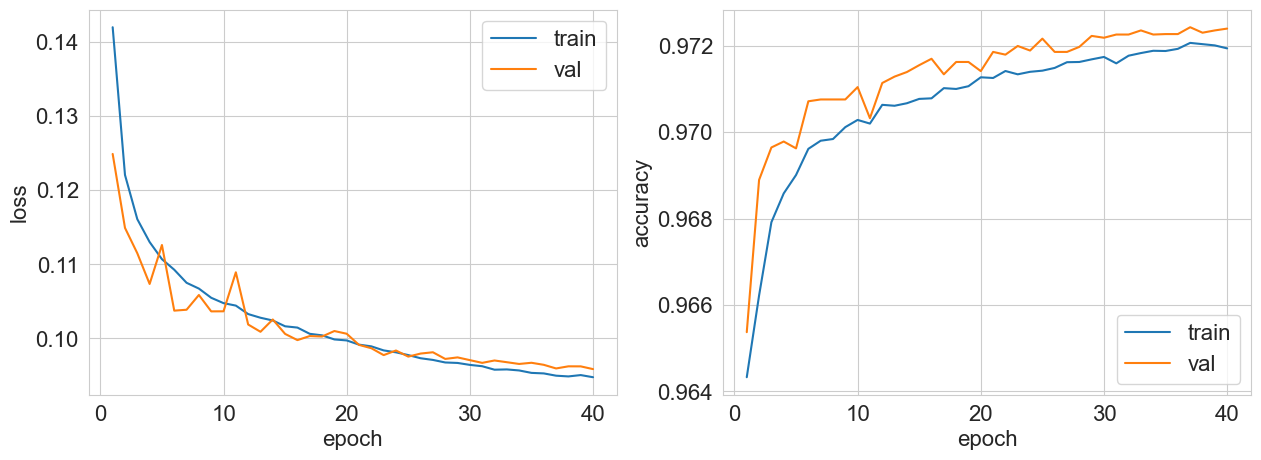

Validation accuracy: 0.972


(0.9719403616947314, 0.9723983193675972)

In [66]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class MLP_5linear(nn.Module):
    def __init__(self, in_features_num, middle_features_num, class_num, dropout_p):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features=in_features_num, out_features=middle_features_num),
            nn.Dropout(p=dropout_p),
            nn.ReLU(),
            nn.Linear(in_features=middle_features_num, out_features=middle_features_num),
            nn.Dropout(p=dropout_p),
            nn.ReLU(),
            nn.Linear(in_features=middle_features_num, out_features=middle_features_num),
            nn.Dropout(p=dropout_p),
            nn.ReLU(),
            nn.Linear(in_features=middle_features_num, out_features=middle_features_num),
            nn.Dropout(p=dropout_p),
            nn.ReLU(),
            nn.Linear(in_features=middle_features_num, out_features=class_num)
        )
    
    def forward(self, x):
        return self.model(x)


train_set = TensorDataset(torch.from_numpy(X_train.values).to(torch.float32), torch.from_numpy(y_train.values))
val_set = TensorDataset(torch.from_numpy(X_val.values).to(torch.float32), torch.from_numpy(y_val.values))

train_loader = DataLoader(train_set, batch_size=512, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=512, shuffle=False, num_workers=2, pin_memory=True)

num_epochs = 40
in_features_num = X_train.shape[1]
middle_features_num = int(X_train.shape[1] * 1)
number_of_classes = 2
dropout_p = 0.1
model_5linear = MLP_5linear(in_features_num, middle_features_num, number_of_classes, dropout_p).to(device)
optimizer = torch.optim.SGD(model_5linear.parameters(), lr=5e-2, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
criterion = nn.CrossEntropyLoss().to(device)
metric = lambda y_pred, y_true: (y_true == y_pred.argmax(dim=1)).sum() / y_true.shape[0]

train_and_validate(model_5linear, optimizer, criterion, metric, train_loader, val_loader,
                       num_epochs, scheduler)


Обучим модель на полной обучающей выборке (объединим train и val выборки). 

In [68]:
train_set = TensorDataset(torch.from_numpy(np.concatenate((X_train.values, X_val.values))).to(torch.float32),
                          torch.from_numpy(np.concatenate((y_train.values, y_val.values))))
val_set = TensorDataset(torch.from_numpy(X_val.values).to(torch.float32), torch.from_numpy(y_val.values))

train_loader = DataLoader(train_set, batch_size=512, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=512, shuffle=False, num_workers=2, pin_memory=True)

num_epochs = 40
in_features_num = X_train.shape[1]
middle_features_num = int(X_train.shape[1] * 1)
number_of_classes = 2
dropout_p = 0.1
model_5linear = MLP_5linear(in_features_num, middle_features_num, number_of_classes, dropout_p).to(device)
optimizer = torch.optim.SGD(model_5linear.parameters(), lr=5e-2, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
criterion = nn.CrossEntropyLoss().to(device)
metric = lambda y_pred, y_true: (y_true == y_pred.argmax(dim=1)).sum() / y_true.shape[0]

train_and_validate(model_5linear, optimizer, criterion, metric, train_loader, val_loader,
                       num_epochs, scheduler, verbose=False)

(0.9726352152449095, 0.9732661636213041)

In [69]:
torch.save({
    'model_state': model_5linear.state_dict(),
    'optimizer_state': optimizer.state_dict(),
    'scheduler_state': scheduler.state_dict()
}, 'linLay5_hidLayFeatNumEqInFeatNum_dropout01_bsize512_epoch40_sgd_mom09_lr5e2_wd1e4_explr09.pt')

## Метрики качества на тестовой выборке

In [81]:
def calc_scores(y_true, pred, pred_proba):
    print('roc_auc_score=', roc_auc_score(y_true, pred_proba))
    precision, recall, _ = precision_recall_curve(y_true, pred_proba)
    print('precision_recall_auc_score', auc(recall, precision))
    print(classification_report(y_true, pred ,digits=3))

In [25]:
X_test = prep_data_pipe.transform(X_test)

Предсказание модели

In [82]:
with torch.no_grad():
    model_5linear.eval()
    pred_test = model_5linear(torch.from_numpy(X_test.values).to(torch.float32))

softmax = nn.Softmax(dim=1)
y_pred_softmax = softmax(pred_test)
y_pred = y_pred_softmax.argmax(dim=1)
calc_scores(y_test.values, y_pred.numpy(), y_pred_softmax.numpy()[:,1])


roc_auc_score= 0.8964102550494374
precision_recall_auc_score 0.4938390975694915
              precision    recall  f1-score   support

           0      0.974     0.997     0.986    113975
           1      0.774     0.276     0.407      4133

    accuracy                          0.972    118108
   macro avg      0.874     0.637     0.696    118108
weighted avg      0.967     0.972     0.965    118108



Константный прогноз. Для всех объектов предсказываем класс "0"

In [83]:
y_const = np.zeros(y_test.size)
calc_scores(y_test.values, y_const, y_const)

roc_auc_score= 0.5
precision_recall_auc_score 0.517496697937481
              precision    recall  f1-score   support

           0      0.965     1.000     0.982    113975
           1      0.000     0.000     0.000      4133

    accuracy                          0.965    118108
   macro avg      0.483     0.500     0.491    118108
weighted avg      0.931     0.965     0.948    118108

